<a href="https://colab.research.google.com/github/jiku100/2020-2-machine-running-proejct/blob/master/assignment9/%EC%8B%A0%EC%84%9D%EA%B2%BD_assignment_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification for Multiple Categories using Pytorch**



# 1. Import library
<hr>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# 2. Load Data
<hr>

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

In [4]:
data_path = './MNIST'

training_set = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
testing_set = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)

In [5]:
batch_32 = 32
batch_64 = 64
batch_128 = 128
learning_rate_value = 1e-2

In [6]:
train_loader_32 = DataLoader(dataset = training_set, batch_size = batch_32, shuffle = True) ## batch size 32 짜리 train loader 생성
test_loader_32 = DataLoader(dataset = testing_set, batch_size = batch_32, shuffle = True) ## batch size 32 짜리 test loader 생성

train_loader_64 = DataLoader(dataset = training_set, batch_size = batch_64, shuffle = True) ## batch size 64 짜리 train loader 생성
test_loader_64 = DataLoader(dataset = testing_set, batch_size = batch_64, shuffle = True) ## batch size 64 짜리 test loader 생성

train_loader_128 = DataLoader(dataset = training_set, batch_size = batch_128, shuffle = True) ## batch size 128 짜리 train loader 생성
test_loader_128 = DataLoader(dataset = testing_set, batch_size = batch_128, shuffle = True) ## batch size 128 짜리 test loader 생성

Target: 2


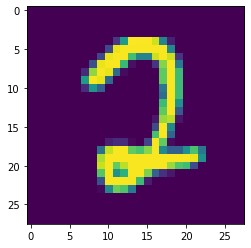

In [7]:
for X, Y in train_loader_32:
  plt.imshow(X[0][0].numpy())
  print(f"Target: {Y[0]}")
  break

# 3. Define Model
<hr>

In [8]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20),
            nn.Sigmoid(),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10),
            nn.Sigmoid(),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=10*10, out_features=10),
            nn.LogSoftmax(dim=1),
        ) 
        
        
    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out


In [9]:
classifier_32 = classification().to(device)
classifier_64 = classification().to(device)
classifier_128 = classification().to(device)

In [10]:
## Loss function
criterion = nn.NLLLoss()

# Optimization
optimizer = torch.optim.SGD(classifier_32.parameters(), lr=learning_rate_value)

# 4. Training
<hr>

In [11]:
training_epochs = 60
total_batch_32 = len(train_loader_32)
total_batch_64 = len(train_loader_64)
total_batch_128 = len(train_loader_128)

In [12]:
print(total_batch_32)

1875


In [13]:
def accuracy(log_pred, y_true):
    y_pred = torch.argmax(log_pred, dim=1)
    return (y_pred == y_true).to(torch.float).mean()

In [14]:
for X, Y in train_loader_32:
  X = X.to(device)
  Y = Y.to(device)
  pred = classifier_32(X)
  print(torch.argmax(pred, dim=1))
  print(Y)
  print((torch.argmax(pred, dim=1) == Y).to(torch.float).mean())
  break

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7], device='cuda:0')
tensor([9, 9, 3, 7, 9, 3, 0, 1, 1, 5, 2, 6, 7, 0, 9, 2, 1, 3, 8, 3, 1, 9, 9, 1,
        9, 9, 3, 1, 4, 7, 7, 1], device='cuda:0')
tensor(0.1250, device='cuda:0')


In [15]:
def training(model, loss, optim, training_epochs, train_loader, test_loader):
  L_iters_train = []
  accuracy_train = []
  L_iters_test = []
  accuracy_test = []
  for epoch in range(training_epochs):
    total_cost_train = 0
    total_cost_test = 0
    total_acc_train = 0
    total_acc_test = 0

    for X, Y in train_loader:
      X = X.to(device)
      Y = Y.to(device)

      optim.zero_grad()
      train_pred = model(X)
      cost = loss(train_pred, Y)
      cost.backward()
      optim.step()
      total_cost_train += cost
      total_acc_train += accuracy(train_pred, Y)
      
    avg_cost_train = total_cost_train / len(train_loader)
    avg_acc_train = total_acc_train / len(train_loader)

    L_iters_train.append(avg_cost_train)
    accuracy_train.append(avg_acc_train)
    with torch.no_grad():
      for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        test_pred = model(X_test)
        cost_test = loss(test_pred, Y_test)
        total_cost_test += cost_test
        total_acc_test += accuracy(test_pred, Y_test)
      avg_cost_test = total_cost_test / len(test_loader)
      avg_acc_test = total_acc_test / len(test_loader)
    
      accuracy_test.append(avg_acc_test)
      L_iters_test.append(avg_cost_test)

    print("Epoch: %02d Training Loss: %.9f Testing Loss: %.9f  Training Acc: %.9f Testing Acc: %.9f" %((epoch + 1),avg_cost_train, avg_cost_test, avg_acc_train, avg_acc_test))
  return L_iters_train, accuracy_train, L_iters_test, accuracy_test

In [16]:
L_train_32, A_train_32, L_test_32, A_test_32 = training(classifier_32, criterion, optimizer, training_epochs, train_loader_32, test_loader_32)

Epoch: 01 Training Loss: 2.165584087 Testing Loss: 1.813946843  Training Acc: 0.348700017 Testing Acc: 0.608925700
Epoch: 02 Training Loss: 1.274011254 Testing Loss: 0.905810654  Training Acc: 0.671666682 Testing Acc: 0.754492819
Epoch: 03 Training Loss: 0.756060362 Testing Loss: 0.619610965  Training Acc: 0.793033361 Testing Acc: 0.833466411
Epoch: 04 Training Loss: 0.559077919 Testing Loss: 0.482919544  Training Acc: 0.848699987 Testing Acc: 0.868909717
Epoch: 05 Training Loss: 0.457443595 Testing Loss: 0.411810517  Training Acc: 0.875766695 Testing Acc: 0.888079047
Epoch: 06 Training Loss: 0.399590760 Testing Loss: 0.365500093  Training Acc: 0.889649987 Testing Acc: 0.897563875
Epoch: 07 Training Loss: 0.363075942 Testing Loss: 0.336923987  Training Acc: 0.898299992 Testing Acc: 0.904452860
Epoch: 08 Training Loss: 0.337513238 Testing Loss: 0.317033559  Training Acc: 0.903966665 Testing Acc: 0.910742819
Epoch: 09 Training Loss: 0.317925155 Testing Loss: 0.300933361  Training Acc: 0.

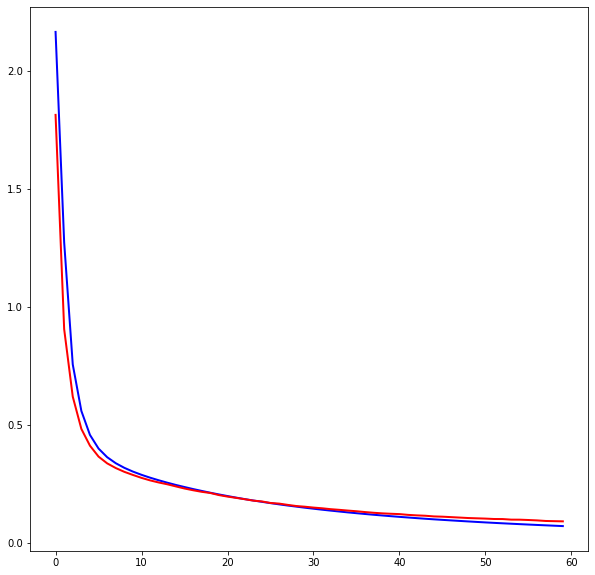

In [17]:
plt.figure(figsize = (10,10))
plt.plot(L_train_32, linewidth = 2, c='b')
plt.plot(L_test_32, linewidth = 2, c='r')
plt.show()

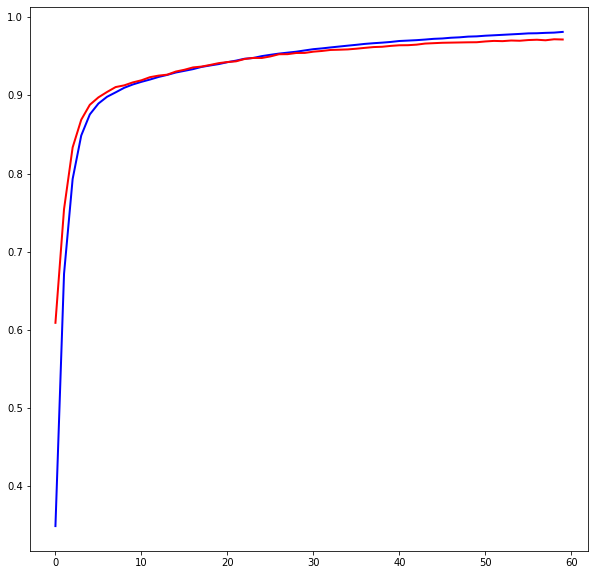

In [18]:
plt.figure(figsize = (10,10))
plt.plot(A_train_32, linewidth = 2, c='b')
plt.plot(A_test_32, linewidth = 2, c='r')
plt.show()

tensor(9, device='cuda:0')


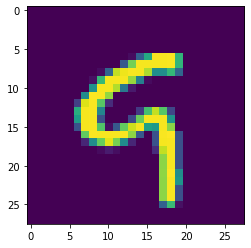

In [19]:
for X, Y in test_loader_32:
    plt.imshow(X[0][0].numpy())
    X_1 = X.to(device)
    pred = classifier_32(X_1)
    print(torch.argmax(pred[0]))
    break